<a href="https://colab.research.google.com/github/Anatoly-Makarevich/time-series-mentoring/blob/master/5_Classic_Multivariate/Topic_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 5 - Classical Multivariate Forecasting

## Overview

This topic covers the classical statistical regression models with exogenous variables
(in the time series context, it's called "dynamic regression") and vector autoregressive
processes (VAR).

## Learning Materials

1. FPP3 [Chapter 10 - Dynamic Regression](https://otexts.com/fpp3/dynamic.html).

2. FPP3 [Section 12.3 - VAR](https://otexts.com/fpp3/VAR.html).

3. Read this [Statsmodels VAR notebook](https://www.statsmodels.org/dev/vector_ar.html).

4. (Bonus/TODO) Read about Granger causality and VECM.

## Tasks

Complete the following tasks with 2 datasets: stock price/volume, and a country's GDP/GNP/unemployment.

**Stocks**: Use a dataset including stock prices and volumes, e.g. [one of these](https://github.com/antoinecarme/TimeSeriesData/tree/master/YahooFinance) or [one of these](https://www.kaggle.com/meetnagadia/stock-price-of-top-10-smartphone-company-20162021).

**Economy**: Use `global_economy` from `py-tsdata`, or directly from
[here](https://github.com/NowanIlfideme/tsdata/raw/main/src/tsdata/raw/fpp3/global_economy.csv).
Select any country with reasonable data quality and quantity.

When building the models, make sure to use a validation split. Also, try out different sets of variables in both cases.

1. Build and analyze a dynamic regression model, including residual diagnostics.

2. Use Prophet instead of a dynamic linear regression.

3. Model several series with a VAR model, with the same setup. How many series does it make sense to model?

4. Compare behavior, errors, coefficients. How best to compare these models?
   Which model makes sense to use for each dataset?


In [1]:
import warnings

# np and pandas

# plotting
import matplotlib.pyplot as plt

from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

# set style of plots
plt.style.use('Solarize_Light2')

from tsdata.raw import  load_data
from sktime.utils.plotting import plot_series

Importing plotly failed. Interactive plots will not work.


We are going to use the close price as our target variable.

array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>],
      dtype=object)

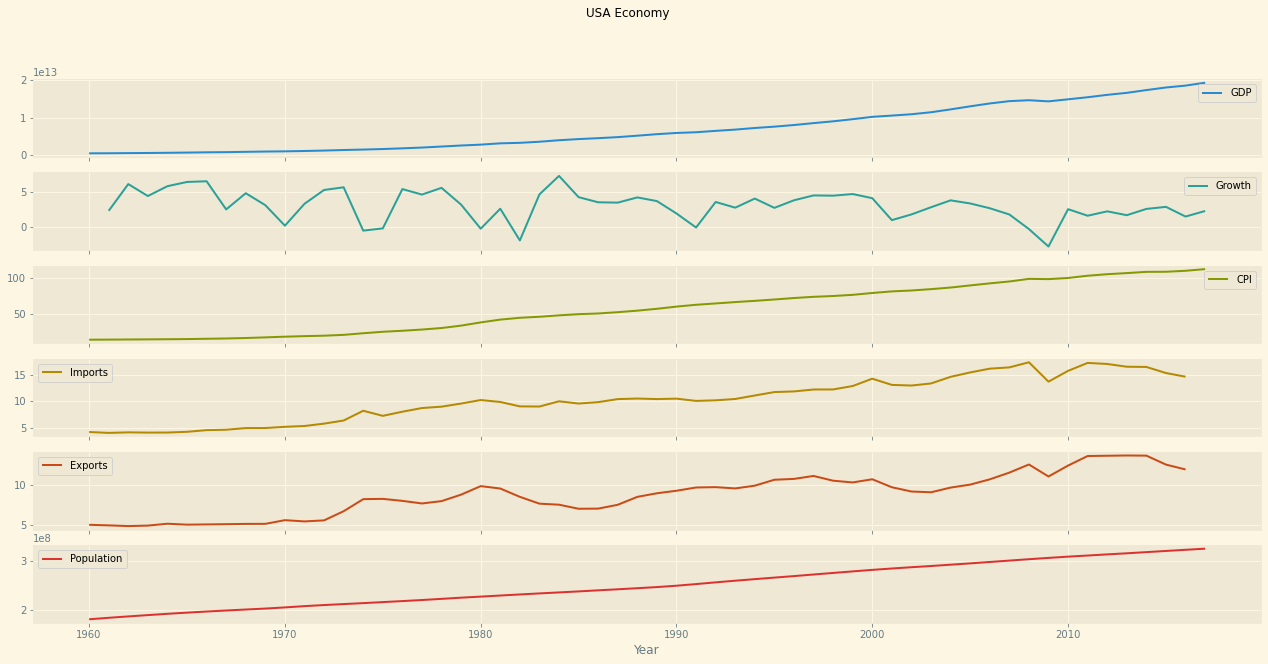

In [52]:
global_economy_df = load_data("global_economy")
is_usa = global_economy_df['Code'] == 'USA'

usa_economy_df = (global_economy_df[is_usa]
 .copy()
 .set_index('Year')
 .drop(['Country', 'Code'], axis=1)
)

(usa_economy_df
 .plot(figsize=(22, 10), subplots=True, title="USA Economy")
)

In [53]:
# specify the target and predictor variables
usa_economy_y = usa_economy_df['Exports']
usa_economy_X = usa_economy_df.drop('Exports', axis=1)

# we are going to test with 10 years of data
YEARS_FOR_TEST = 10

# split the data to a train and test sets
usa_economy_y_train, usa_economy_y_test, usa_economy_X_train, usa_economy_X_test = temporal_train_test_split(
    usa_economy_y, usa_economy_X,
    test_size=YEARS_FOR_TEST
)


In [54]:
usa_economy_X_train.isna().sum().reset_index(name="nan_count")

,index,nan_count
0,GDP,0
1,Growth,1
2,CPI,0
3,Imports,0
4,Population,0


In [74]:
# impute nans with the mean
usa_economy_X_train = usa_economy_X_train.fillna(usa_economy_X_train.mean())
usa_economy_X_test = usa_economy_X_test.fillna(usa_economy_X_test.mean())

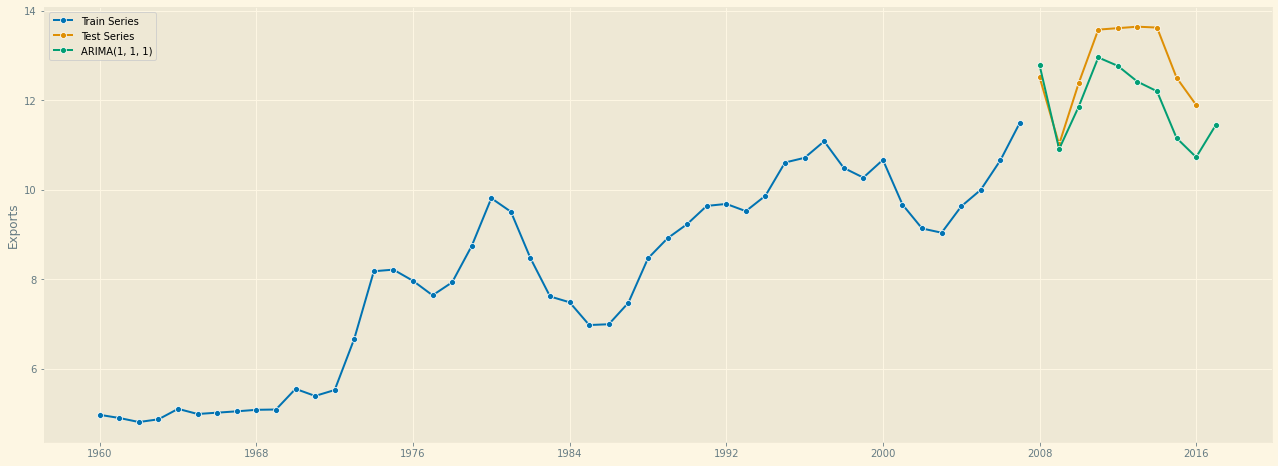

In [147]:
forecast_horizon = ForecastingHorizon(usa_economy_X_test.index, is_relative=False)

arima_model = ARIMA(order=(1, 1, 1), trend='ct', with_intercept=False, suppress_warnings=True)
fit = arima_model.fit(usa_economy_y_train, X=usa_economy_X_train)

arima_pred = arima_model.predict(forecast_horizon, X=usa_economy_X_test)

fig, ax = plot_series(
    usa_economy_y_train,
    usa_economy_y_test,
    arima_pred,
    labels=['Train Series', 'Test Series', 'ARIMA(1, 1, 1)']
)

fig.set_figwidth(22)
fig.set_figheight(8)

### Residual Diagnostics

<AxesSubplot:title={'center':'Residuals Density'}, ylabel='Density'>

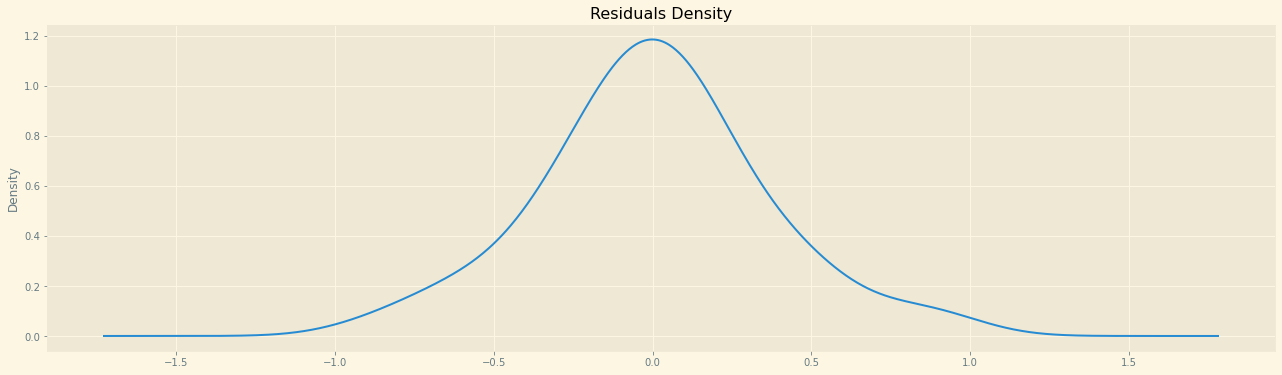

In [131]:
arima_residuals = arima_model._forecaster.resid()[1:]
arima_residuals.plot.density(figsize=(22, 6), title="Residuals Density")

#### Test for a zero mean

In [166]:
from scipy.stats import ttest_1samp
ttest_1samp(arima_residuals, popmean=0)

Ttest_1sampResult(statistic=0.057512732644084456, pvalue=0.9543858706823661)

We cannot reject a zero mean of the residuals sample.

#### Test for normality

JB pvalue is  0.773247193584424
Shapiro pvalue is  0.8401905298233032
Lillie pvalue is  0.4670940754940709


/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_85406/3998488204.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqplot(arima_residuals).show()


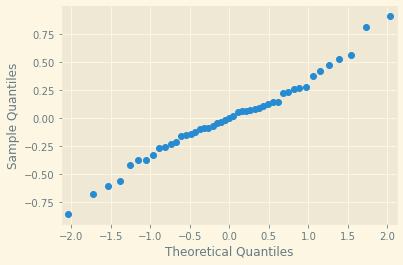

In [160]:
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.graphics.gofplots import qqplot

jb_stat, jb_pvalue = jarque_bera(arima_residuals)
shapiro_stat, shapiro_pvalue = shapiro(arima_residuals)
lillie_stat, lillie_pvalue = lilliefors(arima_residuals, 'norm')

print("JB pvalue is ", jb_pvalue)
print("Shapiro pvalue is ", shapiro_pvalue)
print("Lillie pvalue is ", lillie_pvalue)

qqplot(arima_residuals).show()

We cannot reject normality.

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_85406/3490811127.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(arima_residuals).show()


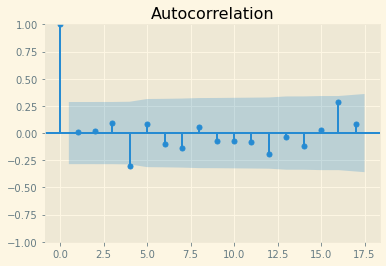

In [138]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

plot_acf(arima_residuals).show()

In [139]:
acorr_ljungbox(arima_residuals, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.21238,0.608101,7.029424,0.722664


We also cannot reject that the residuals is a white noise.

#### Test for heteroscedasticity

In [150]:
from statsmodels.stats.diagnostic import het_arch

_, lm_pval, _, fpval = het_arch(arima_residuals)
# some of the observations are outliers and that's why we get a 
print(lm_pval, fpval)

0.7904884992384826 0.8443112143080327


We also cannot reject heteroscedasticity.